In [1]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


%load_ext autoreload
%autoreload 2
%matplotlib widget

# Load Data from Folders


In [2]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../../../data/benchmark-wsl2"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    files = os.listdir(directory)

    for file in files:

        if "iterationPerformance" not in file:
            continue

        print(f"Processing {file}")

        tuning_algorithm = directory.split("/")[-1]
        ruleset = directory.split("/")[-2]
        scenario = directory.split("/")[-3]

        print(tuning_algorithm, ruleset, scenario)

        with open(os.path.join(directory, file)) as f:
            content = f.read()
            df = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not ruleset in data[scenario]:
            data[scenario][ruleset] = {}

        data[scenario][ruleset][tuning_algorithm] = df

Processing AutoPas_iterationPerformance_Rank0_2024-06-08_19-27-06.csv
FuzzyTuning-3Samples suitability-vs-rest fallingDrop-tune-every-250
Processing AutoPas_iterationPerformance_Rank0_2024-06-07_21-22-46.csv
PredictiveTuning-10Samples line-rank-vs-rest fallingDrop-tune-every-250
Processing AutoPas_iterationPerformance_Rank0_2024-06-07_22-51-24.csv
PredictiveTuning-3Samples line-rank-vs-rest fallingDrop-tune-every-250
Processing AutoPas_iterationPerformance_Rank0_2024-06-07_20-29-09.csv
FuzzyTuning-10Samples line-rank-vs-rest fallingDrop-tune-every-250
Processing AutoPas_iterationPerformance_Rank0_2024-06-07_21-55-58.csv
FullSearch-3Samples line-rank-vs-rest fallingDrop-tune-every-250
Processing AutoPas_iterationPerformance_Rank0_2024-06-07_22-26-29.csv
FuzzyTuning-3Samples line-rank-vs-rest fallingDrop-tune-every-250
Processing AutoPas_iterationPerformance_Rank0_2024-06-07_18-25-37.csv
FullSearch-10Samples line-rank-vs-rest fallingDrop-tune-every-250


In [3]:
#columns
df.describe()

,Iteration,CellSizeFactor,iteratePairwise[ns],remainderTraversal[ns],rebuildNeighborLists[ns],iteratePairwiseTotal[ns],tuning[ns],energyPsys[J],energyPkg[J],energyRam[J]
count,15001.000000,15001.0,1.500100e+04,1.500100e+04,1.500100e+04,1.500100e+04,1.500100e+04,0.0,0.0,0.0
mean,7500.000000,1.0,7.349940e+07,1.638652e+06,7.886862e+06,8.302863e+07,1.728478e+07,NaN,NaN,NaN
std,4330.560029,0.0,4.269361e+07,1.055078e+07,5.996507e+07,7.649944e+07,2.747008e+06,NaN,NaN,NaN
min,0.000000,1.0,2.997030e+07,7.067100e+04,0.000000e+00,3.115568e+07,1.360216e+07,NaN,NaN,NaN
25%,3750.000000,1.0,4.283949e+07,8.799500e+04,0.000000e+00,4.343156e+07,1.623232e+07,NaN,NaN,NaN
50%,7500.000000,1.0,5.403748e+07,9.702100e+04,0.000000e+00,5.588930e+07,1.654796e+07,NaN,NaN,NaN
75%,11250.000000,1.0,9.355448e+07,4.249030e+05,0.000000e+00,1.002355e+08,1.750579e+07,NaN,NaN,NaN
max,15000.000000,1.0,4.906242e+08,2.988391e+08,1.823501e+09,2.232516e+09,7.119878e+07,NaN,NaN,NaN


# Make Line Plot of Smoothed Value over Iterations


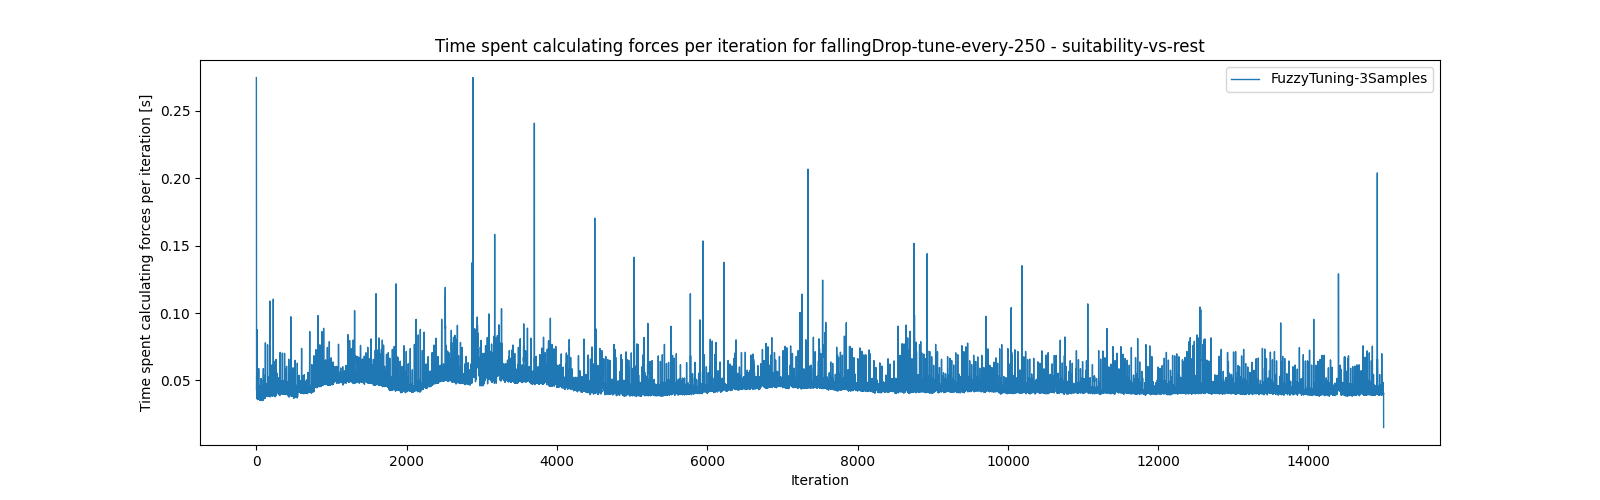

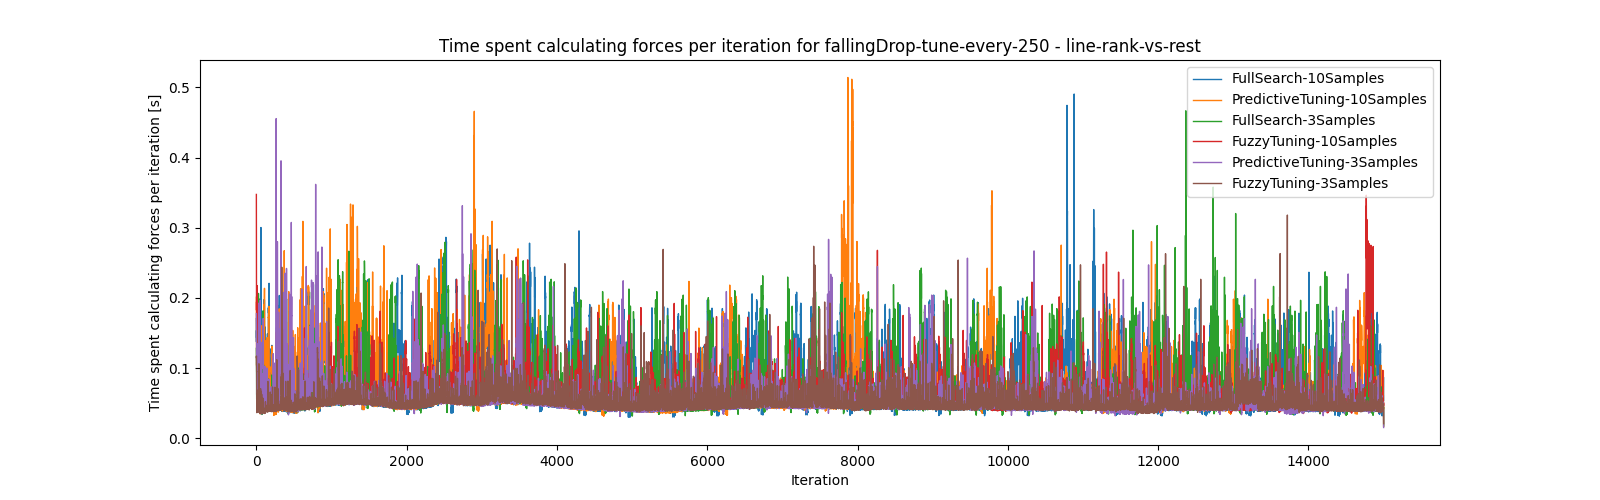

In [4]:


for scenario, tuning_data in data.items():

    for ruleset, tuning_data in tuning_data.items():
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))

        for tuning_algorithm, df in sorted(tuning_data.items(), key=lambda x: x[1]["iteratePairwise[ns]"].mean(), reverse=True):

            time_s = df["iteratePairwise[ns]"] / 1e9

            first_k = 1000000

            x = df["Iteration"][:first_k]
            y = time_s[:first_k]

            linewidth = 1 if "Fuzzy" in tuning_algorithm else 1

            ax.plot(x, y, label=f"{
                    tuning_algorithm}", linewidth=linewidth)

        ax.legend()
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Time spent calculating forces per iteration [s]")
        ax.set_title(f"Time spent calculating forces per iteration for {
                     scenario} - {ruleset}")
        # ax.set_xlim(0, df["Iteration"].max())
        plt.show()

# Make bar plots about total time

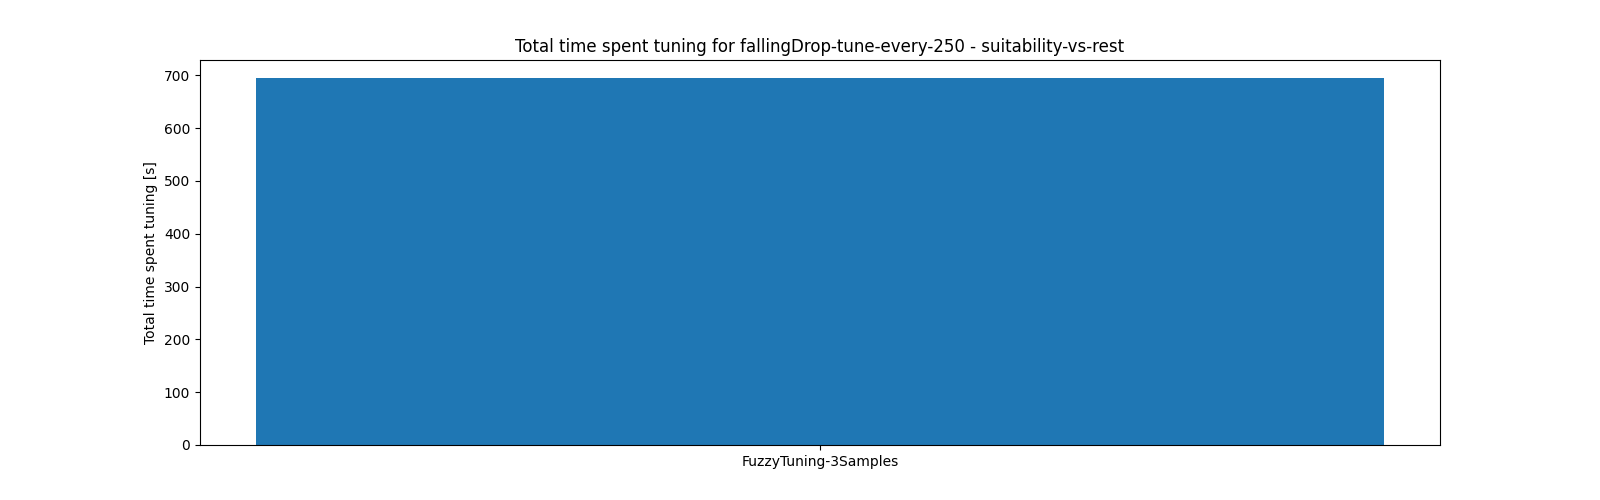

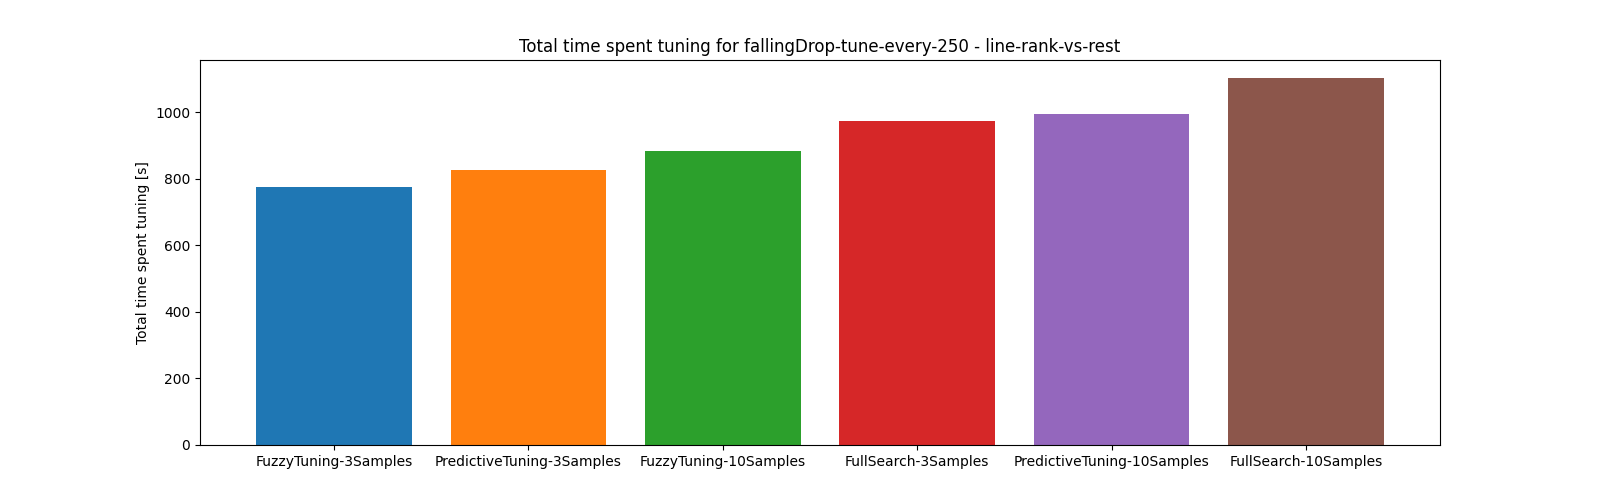

In [5]:

for scenario, tuning_data in data.items():

    for ruleset, tuning_data in tuning_data.items():
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))

        for tuning_algorithm, df in sorted(tuning_data.items(), key=lambda x: x[1]["iteratePairwise[ns]"].mean()):

            total_time_s = df["iteratePairwise[ns]"].sum() / 1e9

            ax.bar(tuning_algorithm, total_time_s, label=f"{tuning_algorithm}")


        ax.set_ylabel("Total time spent tuning [s]")
        ax.set_title(f"Total time spent tuning for {scenario} - {ruleset}")
        # ax.set_yscale("log")
        plt.show()



